## **House Prices Prediction : Modeling**
---
This notebook focuses on building and evaluating predictive models using the engineered features produced in the previous feature engineering stage.

All model specific preprocessing steps including missing value imputation, categorical encoding, and numerical scaling—are implemented within a machine learning pipeline to ensure reproducibility and prevent data leakage.

The modeling process begins with a baseline linear model to assess the effectiveness of the engineered features, followed by systematic evaluation using cross-validation.

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load feature engineered data
train_fe = pd.read_csv('train_fe.csv')
test_fe  = pd.read_csv('test_fe.csv')

print(train_fe.shape, test_fe.shape)
train_fe.head()


(1460, 109) (1459, 108)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,TotalBath,RoomDensity,HasGarage,GarageAge,GarageAreaPerCar,GarageQual_ord,GarageCond_ord,GarageQC,HasMasVnr,LotShapeRatio
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,3.5,190.000000,1,5.0,182.666667,3,3,9,1,0.699497
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,2.5,180.285714,1,31.0,153.333333,3,3,9,0,0.808247
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,3.5,255.142857,1,7.0,202.666667,3,3,9,1,0.635122
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,2.0,214.625000,1,8.0,160.500000,3,3,9,0,0.607754
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,3.5,219.800000,1,8.0,209.000000,3,3,9,1,0.697586


In [16]:
# Split target
y = np.log1p(train_fe['SalePrice'])
X = train_fe.drop(columns=['SalePrice'])

The target variable is log transformed to align with the Kaggle evaluation metric, which computes RMSE in log space.

In [17]:
# Identify numerical and categorical features
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

print(f'Numerical features: {len(num_features)}')
print(f'Categorical features: {len(cat_features)}')

# Create a validation split for model evaluation
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)
print("Train/Valid shapes:", X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

Numerical features: 64
Categorical features: 44
Train/Valid shapes: (1168, 108) (292, 108) (1168,) (292,)


In [8]:
# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)


All model specific preprocessing steps, including imputation, encoding, and scaling, are implemented within a pipeline to prevent data leakage during cross validation.

In [84]:
# Define models
models = {
    'Ridge': Ridge(alpha=1.0),
    
    'RandomForest': RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ),
    
    'XGBoost': XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42
    )
}


In [85]:
# Model evaluation with cross-validation
results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', model)
    ])
    
    rmse = -cross_val_score(
        pipe,
        X,
        y,
        scoring='neg_root_mean_squared_error',
        cv=5
    )
    
    results[name] = rmse.mean()
    print(f'{name} CV RMSE: {rmse.mean():.4f}')


Ridge CV RMSE: 0.1335
RandomForest CV RMSE: 0.1407
XGBoost CV RMSE: 0.1214


Model performance is evaluated using 5-fold cross-validation based on RMSE in log-transformed sale prices. This allows for a fair comparison between linear and non-linear models.

Among the evaluated models, XGBoost achieves the lowest RMSE, indicating better generalization performance on unseen data. Therefore, XGBoost is selected as the final model for generating predictions on the test set.

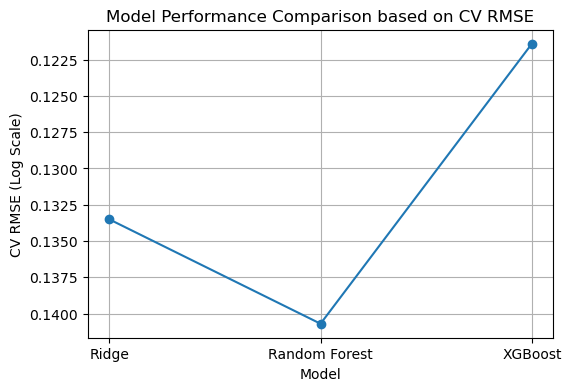

In [86]:
# Visualize model performance
models = ['Ridge', 'Random Forest', 'XGBoost']
rmse_scores = [0.1335, 0.1407, 0.1214]

plt.figure(figsize=(6, 4))
plt.plot(models, rmse_scores, marker='o')
plt.gca().invert_yaxis() 
plt.title('Model Performance Comparison based on CV RMSE')
plt.xlabel('Model')
plt.ylabel('CV RMSE (Log Scale)')
plt.grid(True)
plt.show()

Based on the perfomance compare, XGBoost outperforms Ridge and Random Forest, achieving the lowest RMSE on log-transformed SalePrice.

In [87]:
# Generate predictions for test set
test_pred = np.expm1(final_model.predict(test_fe))

ready = pd.DataFrame({
    'Id': test_fe['Id'],
    'SalePrice': test_pred
})

ready.head()


,Id,SalePrice
0,1461,127555.570312
1,1462,158546.609375
2,1463,183817.312500
3,1464,190620.093750
4,1465,180660.187500


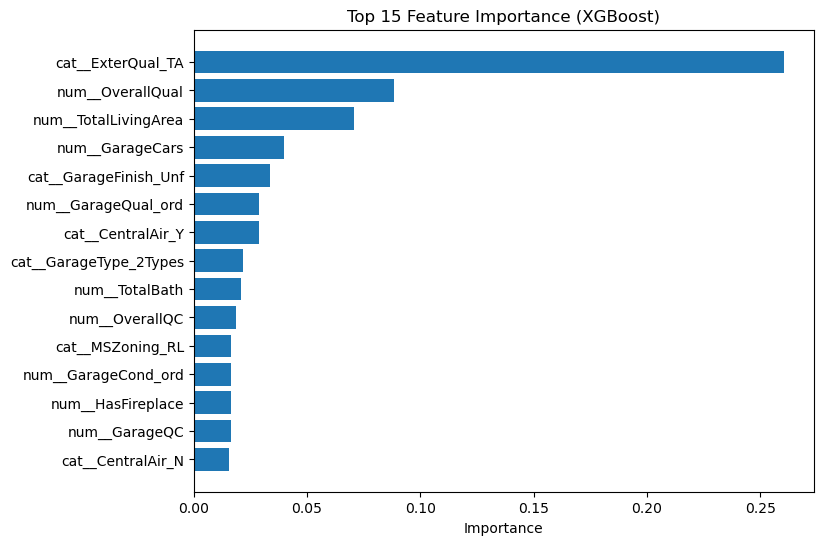

In [88]:
# Feature importance visualization
feature_names = final_model.named_steps['preprocess'].get_feature_names_out()

importances = xgb_model.feature_importances_

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(15)

plt.figure(figsize=(8, 6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importance (XGBoost)')
plt.xlabel('Importance')
plt.show()

The feature importance plot illustrates the top variables contributing to the XGBoost model’s predictions. The dominance of these features indicates that the model successfully captures meaningful structural and economic patterns in the housing market, rather than relying on noise or less relevant attributes.

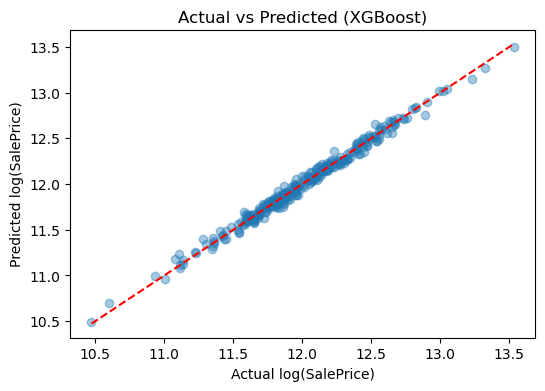

In [89]:
# Visualize model performance on validation set
y_pred = final_model.predict(X_valid)

plt.figure(figsize=(6, 4))
plt.scatter(y_valid, y_pred, alpha=0.4)
plt.plot([y_valid.min(), y_valid.max()],
         [y_valid.min(), y_valid.max()],
         'r--')

plt.xlabel('Actual log(SalePrice)')
plt.ylabel('Predicted log(SalePrice)')
plt.title('Actual vs Predicted (XGBoost)')
plt.show()

The Actual vs Predicted scatter plot shows a strong alignment between the predicted house prices and the true observed values. Most points lie close to the diagonal reference line, indicating that the model produces accurate predictions across a wide range of house prices.

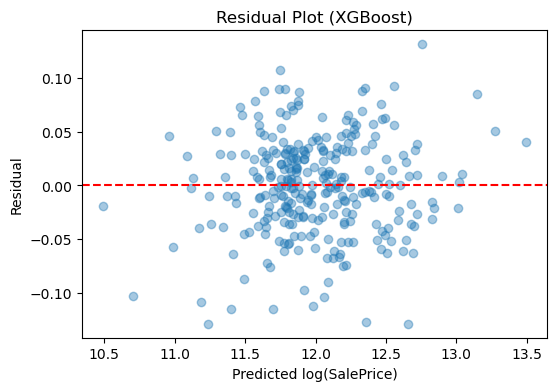

In [90]:
# Residual plot
residuals = y_valid - y_pred

plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted log(SalePrice)')
plt.ylabel('Residual')
plt.title('Residual Plot (XGBoost)')
plt.show()

The residual plot displays the distribution of prediction errors across different predicted values. The residuals are centered around zero with no strong systematic pattern, indicating that the model does not suffer from significant bias.
\

In [91]:
# Save submission file
ready.to_csv('submission_xgboost.csv', index=False)

### **Conclusion**

This notebook evaluated multiple regression models to predict house prices using engineered features and a preprocessing pipeline.

A baseline linear model (Ridge) demonstrated strong performance, indicating that the engineered features capture meaningful structure in the data. Tree-based models were subsequently evaluated, with XGBoost achieving the lowest cross-validated RMSE, suggesting its superior ability to model non-linear relationships and feature interactions.

The final XGBoost model was trained on the full training set and used to generate predictions for the test set.
